In [1]:
# system imports
import os
import sys

# data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

# misc
import warnings

In [2]:
# style settings
sns.set(style='whitegrid', rc={'axes.facecolor': '#EFF2F7'})

# sample frequency for ECG sensor
settings = {}
settings['fs'] = 500

In [18]:
# data recorded with the ECG sensor
df1 = pd.read_csv(r"C:\Users\x\Downloads\x.csv", header=0)
df1

,MLII
0,1.86
1,1.87
2,1.88
3,1.89
4,1.89
...,...
495,1.80
496,1.82
497,1.82
498,1.82


In [19]:
len(df1)

500

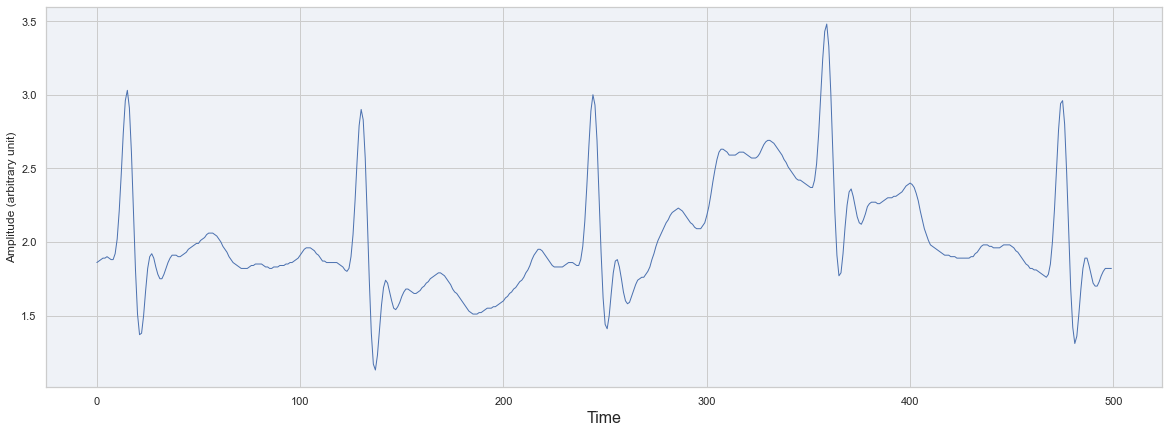

In [5]:
plt.figure(figsize=(20, 7))
start = 0
stop = 500
duration = (stop-start) / settings['fs']
plt.plot(df1,linewidth=1)
plt.xlabel("Time", fontsize=16)
plt.ylabel("Amplitude (arbitrary unit)")
plt.show()

In [6]:
def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter, which is just a part of the sine function
        t = np.linspace(2.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity


In [7]:
def get_plot_ranges(start=0, end=50, n=5):
    '''
    Make an iterator that divides into n or n+1 ranges. 
    - if end-start is divisible by steps, return n ranges
    - if end-start is not divisible by steps, return n+1 ranges, where the last range is smaller and ends at n
    
    # Example:
    >> list(get_plot_ranges())
    >> [(0.0, 3.0), (3.0, 6.0), (6.0, 9.0)]

    '''
    distance = end - start
    for i in np.arange(start, end, np.floor(distance/n)):
        yield (int(i), int(np.minimum(end, np.floor(distance/n) + i)))

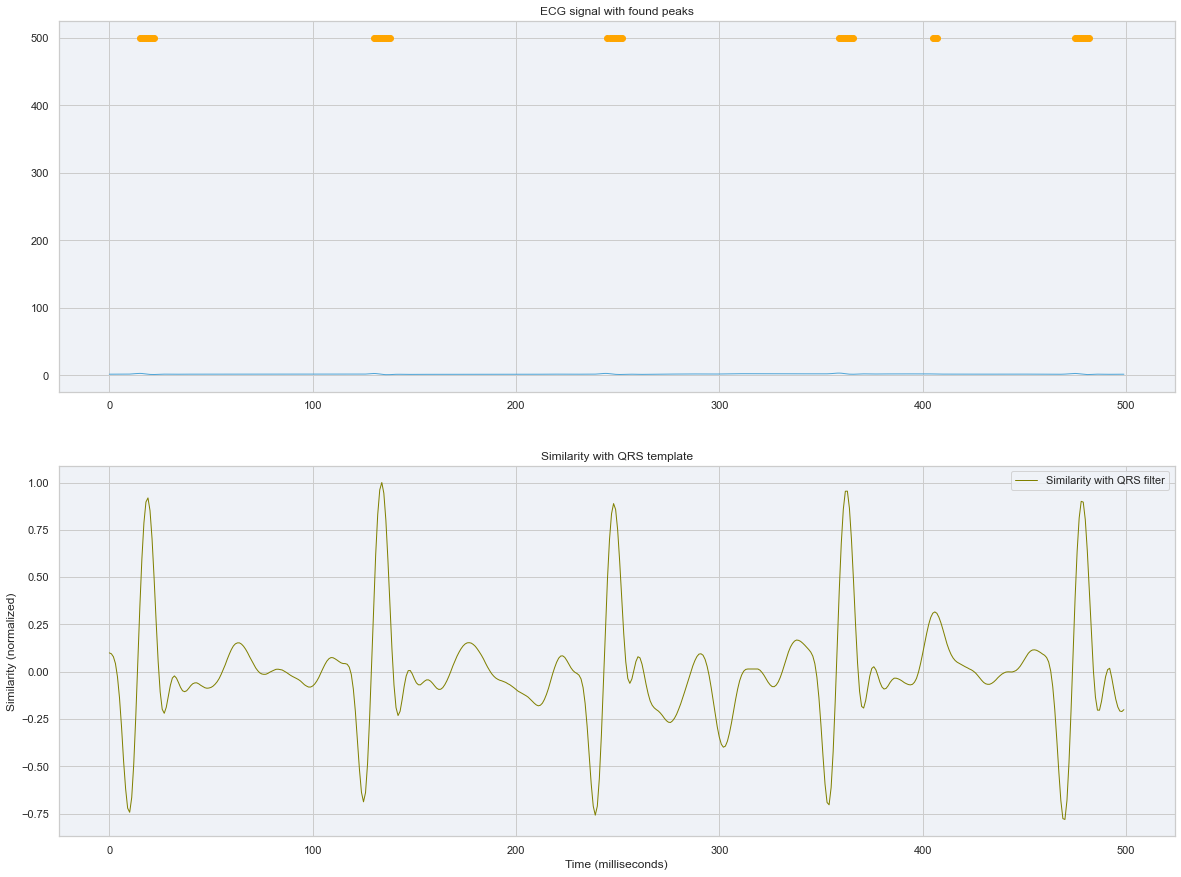

In [8]:
sampfrom = 0
sampto = 21600
nr_plots = 1

for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
    # get slice data of ECG data
    cond_slice = (df1.index >= start) & (df1.index < stop) 
    ecg_slice = df1.MLII[cond_slice]

    # detect peaks
    peaks, similarity = detect_peaks(ecg_slice, threshold=0.3)
    
    # plot similarity
    plt.figure(figsize=(20, 15))

    plt.subplot(211)
    plt.title("ECG signal with found peaks")
    plt.plot(ecg_slice.index, ecg_slice, label="ECG", color="#51A6D8", linewidth=1)
    plt.plot(peaks, np.repeat(500, peaks.shape[0]), label="peaks", color="orange", marker="o", linestyle="None")
#     plt.legend(loc="upper right")
#     plt.xlabel("Time (milliseconds)")
#     plt.ylabel("Amplitude (arbitrary unit)")
    
    plt.subplot(212)
    plt.title('Similarity with QRS template')
    plt.plot(ecg_slice.index, similarity, label="Similarity with QRS filter", color="olive", linewidth=1)
    plt.legend(loc="upper right")
    plt.xlabel("Time (milliseconds)")
    plt.ylabel("Similarity (normalized)")

In [9]:
peaks, similarity = detect_peaks(ecg_slice, threshold=0.3)
print(list(peaks))

[15, 16, 17, 18, 19, 20, 21, 22, 130, 131, 132, 133, 134, 135, 136, 137, 138, 245, 246, 247, 248, 249, 250, 251, 252, 359, 360, 361, 362, 363, 364, 365, 366, 405, 406, 407, 475, 476, 477, 478, 479, 480, 481, 482]


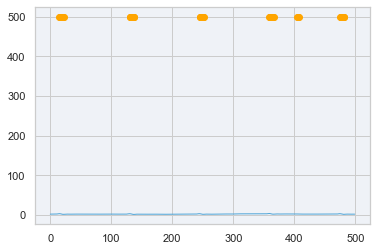

In [10]:
plt.plot(ecg_slice.index, ecg_slice, label="ECG", color="#51A6D8", linewidth=1)
plt.plot(peaks, np.repeat(500, peaks.shape[0]), label="peaks", color="orange", marker="o", linestyle="None")

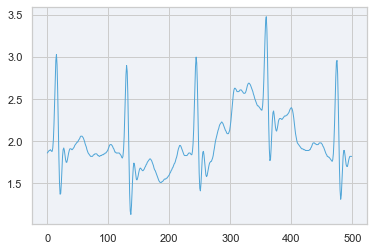

In [11]:
plt.plot(ecg_slice.index, ecg_slice, label="ECG", color="#51A6D8", linewidth=1)

In [12]:
def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)

    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output

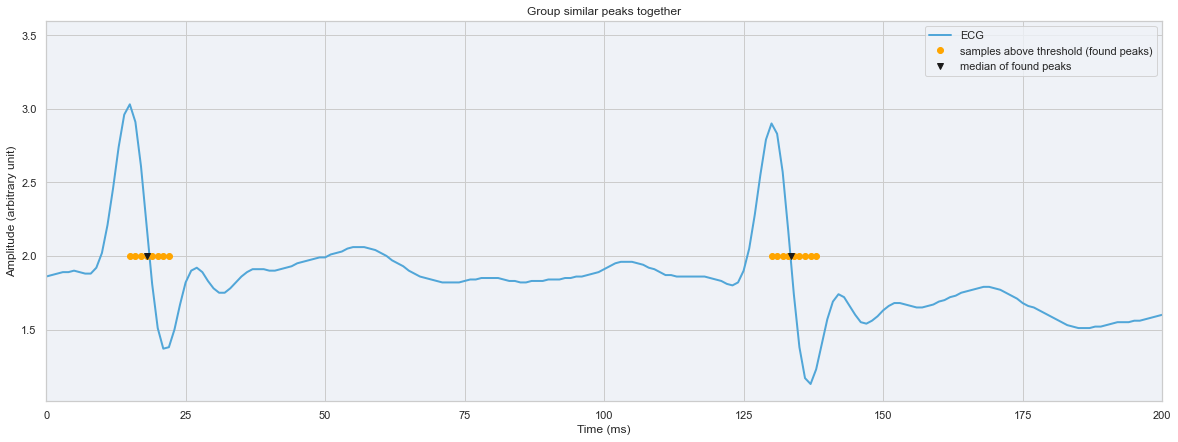

In [13]:
# detect peaks
peaks, similarity = detect_peaks(df1.MLII, threshold=0.3)

# group peaks
grouped_peaks = group_peaks(peaks)

# plot peaks
plt.figure(figsize=(20, 7))
plt.title("Group similar peaks together")
plt.plot(df1.index, df1.MLII, label="ECG", color="#51A6D8", linewidth=2)

plt.plot(peaks, np.repeat(2, peaks.shape[0]),label="samples above threshold (found peaks)", color="orange", marker="o", linestyle="None")
plt.plot(grouped_peaks, np.repeat(2, grouped_peaks.shape[0]), label="median of found peaks", color="k", marker="v", linestyle="None")
plt.legend(loc="upper right")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude (arbitrary unit)")
plt.gca().set_xlim(0, 200)
plt.show()

In [14]:
q=grouped_peaks
q

array([ 18. , 133.5, 248. , 362. , 405.5, 478. ])

In [17]:
len(q)

6

In [15]:
# convert numpy array to dataframe
df = pd.DataFrame(q, columns =['A'])
df

,A
0,18.0
1,133.5
2,248.0
3,362.0
4,405.5
5,478.0


In [16]:
# using loop
b =[]
for i in range(0, len(q)):
    b.append(int(q[i]))
b

[18, 133, 248, 362, 405, 478]

In [66]:
a= []
t= []
for i in range(len(b)):
    
    f = df1.loc[df1["MLII"].index == b[i]]
    ag= f["Elapsed time"].tolist()
    #ag[0] = eval(ag[0])
    t.append(ag)
t


[["'1:30.756'"],
 ["'1:31.314'"],
 ["'1:31.814'"],
 ["'1:33.000'"],
 ["'1:33.494'"],
 ["'1:33.983'"],
 ["'1:35.303'"],
 ["'1:36.306'"],
 ["'1:36.844'"],
 ["'1:38.014'"],
 ["'1:38.539'"],
 ["'1:39.022'"],
 ["'1:40.294'"],
 ["'1:40.822'"],
 ["'1:42.117'"],
 ["'1:42.661'"],
 ["'1:43.156'"],
 ["'1:44.406'"],
 ["'1:45.325'"],
 ["'1:45.831'"],
 ["'1:46.328'"],
 ["'1:47.667'"],
 ["'1:48.178'"],
 ["'1:48.694'"],
 ["'1:49.986'"],
 ["'1:50.853'"],
 ["'1:51.367'"],
 ["'1:51.847'"],
 ["'1:53.108'"],
 ["'1:53.994'"],
 ["'1:54.522'"],
 ["'1:55.014'"],
 ["'1:56.225'"],
 ["'1:56.692'"],
 ["'1:57.900'"],
 ["'1:58.419'"],
 ["'1:58.911'"],
 ["'2:00.222'"],
 ["'2:00.739'"],
 ["'2:01.975'"],
 ["'2:02.469'"],
 ["'2:03.644'"],
 ["'2:04.164'"],
 ["'2:04.661'"],
 ["'2:05.986'"],
 ["'2:06.500'"],
 ["'2:07.722'"],
 ["'2:08.228'"],
 ["'2:08.703'"],
 ["'2:09.950'"],
 ["'2:10.450'"],
 ["'2:11.717'"],
 ["'2:12.256'"],
 ["'2:13.972'"],
 ["'2:14.464'"],
 ["'2:14.942'"],
 ["'2:16.150'"],
 ["'2:16.661'"],
 ["'2:17.186'"

In [67]:
from datetime import datetime
k = []
# Convert string to datetime.time object
for i in range(len(t)):
    
    time_obj = datetime.strptime(t[i][0], "'%M:%S.%f'").time()
    k.append(time_obj)
k

[datetime.time(0, 1, 30, 756000),
 datetime.time(0, 1, 31, 314000),
 datetime.time(0, 1, 31, 814000),
 datetime.time(0, 1, 33),
 datetime.time(0, 1, 33, 494000),
 datetime.time(0, 1, 33, 983000),
 datetime.time(0, 1, 35, 303000),
 datetime.time(0, 1, 36, 306000),
 datetime.time(0, 1, 36, 844000),
 datetime.time(0, 1, 38, 14000),
 datetime.time(0, 1, 38, 539000),
 datetime.time(0, 1, 39, 22000),
 datetime.time(0, 1, 40, 294000),
 datetime.time(0, 1, 40, 822000),
 datetime.time(0, 1, 42, 117000),
 datetime.time(0, 1, 42, 661000),
 datetime.time(0, 1, 43, 156000),
 datetime.time(0, 1, 44, 406000),
 datetime.time(0, 1, 45, 325000),
 datetime.time(0, 1, 45, 831000),
 datetime.time(0, 1, 46, 328000),
 datetime.time(0, 1, 47, 667000),
 datetime.time(0, 1, 48, 178000),
 datetime.time(0, 1, 48, 694000),
 datetime.time(0, 1, 49, 986000),
 datetime.time(0, 1, 50, 853000),
 datetime.time(0, 1, 51, 367000),
 datetime.time(0, 1, 51, 847000),
 datetime.time(0, 1, 53, 108000),
 datetime.time(0, 1, 53,

In [68]:
from datetime import datetime
from datetime import timedelta
b = []
g = []
for i in range(len(t)-1):

    t1 = datetime.strptime(t[i][0], "'%M:%S.%f'")
    t2 = datetime.strptime(t[i+1][0], "'%M:%S.%f'")
#     print(t1,t2)
    delta = t2 - t1
    g.append(delta.microseconds)
    b.append(delta.seconds)
    
    # print(delta.seconds,delta.microseconds)
g

[558000,
 500000,
 186000,
 494000,
 489000,
 320000,
 3000,
 538000,
 170000,
 525000,
 483000,
 272000,
 528000,
 295000,
 544000,
 495000,
 250000,
 919000,
 506000,
 497000,
 339000,
 511000,
 516000,
 292000,
 867000,
 514000,
 480000,
 261000,
 886000,
 528000,
 492000,
 211000,
 467000,
 208000,
 519000,
 492000,
 311000,
 517000,
 236000,
 494000,
 175000,
 520000,
 497000,
 325000,
 514000,
 222000,
 506000,
 475000,
 247000,
 500000,
 267000,
 539000,
 716000,
 492000,
 478000,
 208000,
 511000,
 525000,
 258000,
 523000,
 114000,
 511000,
 472000,
 203000,
 527000,
 248000,
 522000,
 494000,
 236000,
 489000,
 217000,
 839000,
 822000]

In [69]:
df2 = pd.DataFrame(g, columns =['A'])
df2

,A
0,558000
1,500000
2,186000
3,494000
4,489000
...,...
68,236000
69,489000
70,217000
71,839000


In [70]:
def cal_average(num):
    sum_num = 0
    for l in num:
        sum_num = sum_num + l          

    avg = sum_num / len(num)
    return avg

print( cal_average(g))

437054.79452054796


In [71]:
min=850000
max=1150000
a=[]
b=[]
for i in range(len(g)):
    if g[i]>=min and g[i]<=max:
        a.append(g[i])
    else:
        b.append(g[i])
print(a)
                 

[919000, 867000, 886000]


In [72]:
from datetime import datetime
from datetime import timedelta
z=[]
f = []
for i in range(len(g)-1):
    m1 = (g[i] +g[i+1])/2
    m2 =  (b[i] +b[i+1])/2
    
#     print(t1,t2)
    z.append(m1)
    f.append(m2)
z

IndexError: list index out of range

In [ ]:
jj=[]
if jj >=len(g):
    print(ff)

In [ ]:

res1 = 0
for num in num_list:
    res1 += num
avg1 = res1 / len(num_list)
print("sum is: ", res1, "Average is: ", avg1)

In [ ]:
dates = np.array(['2017-09-15 07:11:00' ,'2017-09-15 11:25:30', '2017-09-15 12:11:10', '2021-04-07 22:43:12', '2021-04-08 00:49:18'], 
                dtype="datetime64[ns]")

delta_s = np.diff(dates).astype('timedelta64[s]') # nanoseconds to seconds

print(delta_s)